Построение решения с учетом суперпозиции

In [1]:
!pip install anaflow

In [2]:
# импортируем библиотки, которые могут пригодиться для проведения расчетов
import numpy as np
import matplotlib.pyplot as plt
from anaflow import get_lap_inv
from scipy.special import kn, iv, expi

In [3]:
# определим функции для перевода размерных переменных в безразмерные и обратно
# пригодится потом для построения графиков и ведения расчетов

# при наименовании функций придерживаемся следующих соглашений
# сначала идет название того, что считаем
# в конце указывается размерность результата, если это уместно

def r_from_rd_m(rd, rw_m=0.1):
    """
    перевод безразмерного расстояния в размерное
    rd -  безразмерное расстояние
    rw_m -  радиус скважины, м
    """
    return rd*rw_m

def rd_from_r(r_m, rw_m=0.1):
    """
    перевод размерного расстояния в безразмерное
    r_m - размерное расстояние, м
    rw_m - радиус скважины, м
    """
    return r_m/rw_m

def t_from_td_hr(td, k_mD=10, phi=0.2, mu_cP=1, ct_1atm=1e-5, rw_m=0.1):
    """
    перевод безразмерного времени в размерное, результат в часах
    td - безразмерное время
    k_mD - проницаемость пласта, мД
    phi - пористость, доли единиц
    mu_cP - динамическая вязкость флюида, сП
    ct_1atm - общая сжимаемость, 1/атм
    rw_m - радиус скважины, м
    """
    return td * phi * mu_cP * ct_1atm * rw_m * rw_m / k_mD / 0.00036

def td_from_t(t_hr, k_mD=10, phi=0.2, mu_cP=1, ct_1atm=1e-5, rw_m=0.1):
    """
    перевод размерного времени в безразмерное
    t_hr - размерное время, час
    k_mD - проницаемость пласта, мД
    phi - пористость, доли единиц
    mu_cP - динамическая вязкость флюида, сП
    ct_1atm - общая сжимаемость, 1/атм
    rw_m - радиус скважины, м
    """
    return  0.00036 * t_hr * k_mD / (phi * mu_cP * ct_1atm * rw_m * rw_m) 

def p_from_pd_atma(pd, k_mD=10, h_m=10, q_sm3day=20, b_m3m3=1.2, mu_cP=1, pi_atma=250):
    """
    перевод безразмерного давления в размерное, результат в абсолютных атмосферах
    pd - безразмерное давление
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    q_sm3day - дебит на поверхности, м3/сут в с.у.
    fvf_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    pi_atma - начальное давление, абсолютные атм.
    """
    return pi_atma - pd * 18.41 * q_sm3day * b_m3m3 * mu_cP / k_mD / h_m 

def pd_from_p(p_atma, k_mD=10, h_m=10, q_sm3day=20, b_m3m3=1.2, mu_cP=1, pi_atma=250):
    """
    перевод размерного давления в безразмерное
    p_atma - давление
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    q_sm3day - дебит на поверхности, м3/сут в с.у.
    fvf_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    pi_atma - начальное давление, абсолютные атм.
    """
    return (pi_atma - p_atma) / (18.41 * q_sm3day * b_m3m3 * mu_cP) * k_mD * h_m 

In [4]:
# Решение линейного стока уравнения фильтрации
def pd_ei(td, rd=1):
    """
    Решение линейного стока уравнения фильтрации
    rd - безразмерное расстояние
    td - безразмерное время
    """
    return -1/2*expi(-rd**2 / 4 / td)

# простой случай - восстановление давления


In [5]:
t_p_hr = 24  # время работы скважины

In [6]:
def pd_build_up(td, td_p):
    """
    расчет давления для запуска и последующей остановки скважины
    td - время после запуска
    td_p - время безразмерное - которое скважина работала до остановки
    """
    p_d=[]
    for ti in td:
        if ti < td_p:
            p_d.append(pd_ei(ti))
        else:
            p_d.append(pd_ei(ti) - pd_ei(td_p-ti))
    return np.array(p_d)
        

Функция Хевисайда

$$ \mathcal{H} = \begin{cases}0 & x < 0\\1 & x = 0\\1 & x > 0\end{cases}$$

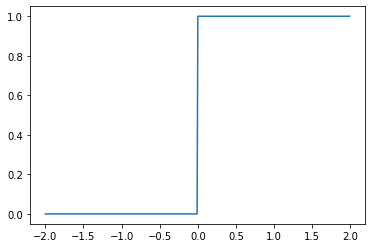

In [7]:
x = np.arange(-2,2,0.01)
y = np.heaviside(x, 1)

plt.plot(x,y)
plt.show()

In [8]:
def pd_build_up(td, td_p):
    """
    расчет давления для запуска и последующей остановки скважины
    td - время после запуска
    td_p - время безразмерное - которое скважина работала до остановки
    """

    return pd_ei(td) - np.heaviside(td-td_p,1) * pd_ei(td-td_p)
    

In [9]:
t_arr = np.arange(1e-3, 48, 1e-2)

In [10]:
# переведем размерный массив време в безразмерные величины
td_arr = td_from_t(t_arr)

In [11]:
td_prod = td_from_t(t_p_hr)
print(td_prod)

4319999.999999999


In [12]:
pd_arr = pd_build_up(td_arr, td_prod)

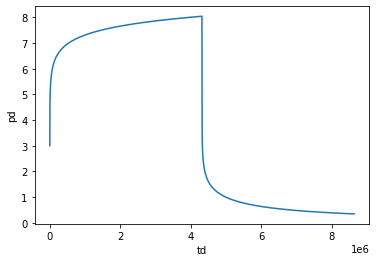

In [13]:
plt.plot(td_arr, pd_arr)
plt.xlabel('td')
plt.ylabel('pd')
plt.show()

In [14]:
p_arr = p_from_pd_atma(pd_arr)

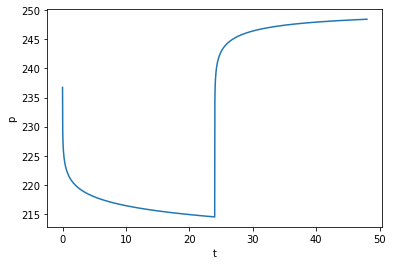

In [15]:
plt.plot(t_arr, p_arr)
plt.xlabel('t')
plt.ylabel('p')
plt.show()

# случай для произвольной истории дебитов

In [16]:
import pandas as pd

In [154]:
# создадим историю изменения дебитов 

q_history = pd.DataFrame({'t_hr':[0,2,24 ], 'q_sm3day':[10,5,0]})

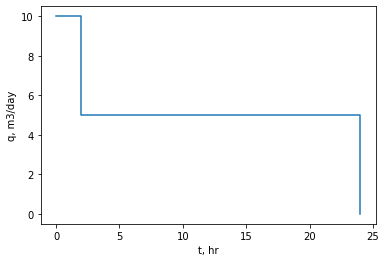

In [157]:
plt.step(q_history.t_hr, q_history.q_sm3day, where = 'post')
plt.xlabel('t, hr')
plt.ylabel('q, m3/day')
plt.show()

In [158]:
q_history

,t_hr,q_sm3day
0,0,10
1,2,5
2,24,0


Безразмерное давление 
$$ p_D = \frac{kh}{ 18.41 q_s B \mu} \left( p_i - p \right) $$

выбор безразмерного давления зависит от дебита $q_s$

$$p = \sum_i p\left(t=t-t_i,q={q_{i}-q_{i-1}}\right)\cdot \theta(t-t_i)$$

In [183]:
def p_superposition_atma(t_hr, df_history):
    """
    расчет давления для запуска и последующей остановки скважины
    t_hr - время после запуска в часах
    df_history - расписание дебитов скважины в виде DataFrame - часы и дебиты с м3/сут
                 должно быть отсортировано по времени
    """
    dp=0      # создаем пустой список, куда будем возвращать результаты
    td = td_from_t(t_hr)
    q_ref = 10
    
    for index, row in df_history.iterrows():
        
        t_prod_hr = row['t_hr']     # время последнего изменения дебита
        q_prod_sm3day = row['q_sm3day']  # последний дебит
        
        if index > 0:
            q_delta_sm3day = q_history.iloc[index]['q_sm3day'] - q_history.iloc[index-1]['q_sm3day']
        else:
            q_delta_sm3day = q_history.iloc[index]['q_sm3day']
        
        
        t_calc = t_hr - t_prod_hr     # время работы текущей мнимой скважины
        td = td_from_t(t_calc)
        
        #print(t_prod_hr, q_delta_sm3day,  np.heaviside(t_calc, 1))
        #print(p_from_pd_atma(q_delta_sm3day/q_ref * pd_ei(td)))
        dp = dp + q_delta_sm3day/q_ref * pd_ei(td) * np.heaviside(t_calc, 1)
    return p_from_pd_atma(dp, q_sm3day = q_ref)


def q_superposition_sm3day(t_hr, df_history):
    """
    расчет давления для запуска и последующей остановки скважины
    t_hr - время после запуска в часах
    df_history - расписание дебитов скважины в виде DataFrame - часы и дебиты с м3/сут
                 должно быть отсортировано по времени
    """
    dp=0      # создаем пустой список, куда будем возвращать результаты
    td = td_from_t(t_hr)
    q_ref = 10
    
    for index, row in df_history.iterrows():
        
        t_prod_hr = row['t_hr']     # время последнего изменения дебита
        q_prod_sm3day = row['q_sm3day']  # последний дебит
        
        if t_hr < t_prod_hr:
            return q_prod_sm3day


In [186]:
q_superposition_sm3day(t_arr, q_history)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

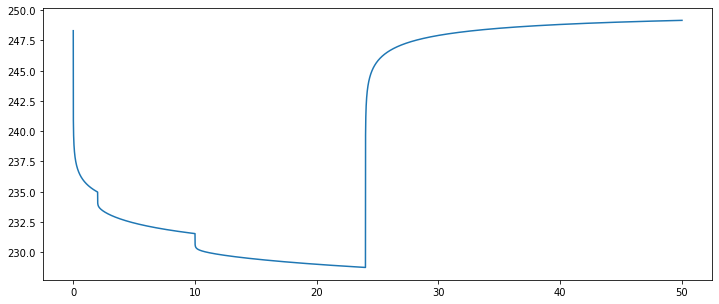

In [199]:
t_arr = np.arange(1e-5, 50, 1e-4)
plt.rcParams["figure.figsize"] = (12,5)

fig, ax1 = plt.subplots(1,1)
#ax1.step(q_history.t_hr, q_history.q_sm3day, where = 'post')
#ax1.plot(t_arr, q_superposition_sm3day(t_arr, q_history)) 
ax1.plot(t_arr, p_superposition_atma(t_arr, q_history)) 

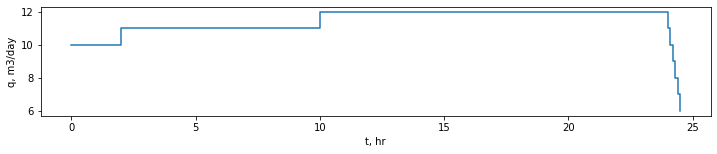

In [201]:

q_history = pd.DataFrame({'t_hr':[0, 2, 10, 24, 24.1,24.2,24.3,24.4,24.5 ], 'q_sm3day':[10,11, 12,11,10,9,8,7, 6]})

plt.rcParams["figure.figsize"] = (12,2)
plt.step(q_history.t_hr, q_history.q_sm3day, where = 'post')
plt.xlabel('t, hr')
plt.ylabel('q, m3/day')
plt.show()

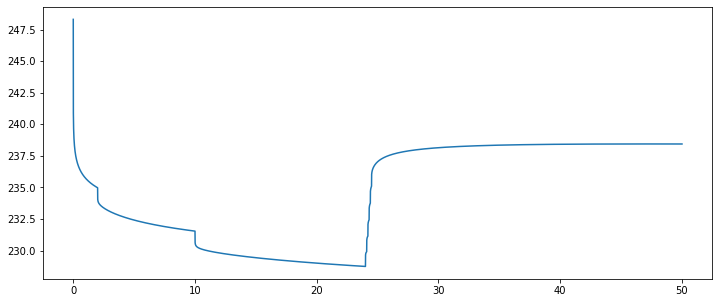

In [202]:
t_arr = np.arange(1e-5, 50, 1e-4)
plt.rcParams["figure.figsize"] = (12,5)

fig, ax1 = plt.subplots(1,1)
#ax1.step(q_history.t_hr, q_history.q_sm3day, where = 'post')
#ax1.plot(t_arr, q_superposition_sm3day(t_arr, q_history)) 
ax1.plot(t_arr, p_superposition_atma(t_arr, q_history)) 